# Credit card fraud detection modeling

## 0 - Functions and librairies

In [52]:
import matplotlib as plt
import pandas as pd
import sklearn as sk
import seaborn as sns
import numpy as np
#import imblearn
#import collections

In [2]:
from pandas import read_csv
from sklearn.metrics import fbeta_score,make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import tree
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
#from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [20]:
from sklearn import tree

In [21]:
df = pd.read_csv("df_clean2.csv",delimiter=',')

In [22]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [23]:
def prepare_dataset(df):
    last_col = len(df.columns) - 1
    X, y = df.iloc[:,0:last_col-1],df.iloc[:,last_col] 
    return X, y

In [24]:
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [25]:
# model evaluation
def evaluate_model(X, y, model):
    # evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #evaluation metric
    metric = make_scorer(f2_score)
    f2_scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
    return f2_scores,accuracy_scores

In [26]:
# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # Naive Bayes
    models.append(GaussianNB())
    names.append('NB')
    # GPC
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    #Knn
    models.append(KNeighborsClassifier())
    names.append('KNN')
    #Decision tree
    models.append(tree.DecisionTreeClassifier())
    names.append('Decision Tree')
    return models, names

In [27]:
df.sample(5)

,transaction_amount,is_declined,total_number_declines_per_day,is_foreign_transaction,is_high_risk_country,daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,is_fraudulent
2118,6750.617609,0,0,0,0,0,0.0,0,0
809,10588.867510,0,0,0,0,0,0.0,0,0
474,15516.344830,0,0,1,0,918,781.0,2,0
42,33359.445320,0,8,1,0,0,0.0,0,1
1840,659.908639,0,0,0,0,0,0.0,0,0


## 1 - Modeling

### A - Baseline naive classifier 

In [28]:
# Separating features and target

In [29]:
X, y = prepare_dataset(df)

In [30]:
#Creating a dummy classifier that always predict the minority class as a baseline
model = DummyClassifier(strategy='constant', constant=1)

In [31]:
# Evaluate the dummy classifier
f2_scores, accuracy_scores = evaluate_model(X, y, model)

In [32]:
print('Mean accuracy: %.3f (%.3f)' % (accuracy_scores.mean(), accuracy_scores.std()))

Mean accuracy: 0.150 (0.001)


In [33]:
print('Mean F2: %.3f (%.3f)' % (f2_scores.mean(), f2_scores.std()))

Mean F2: 0.469 (0.002)


#### Credit card fraud detection is an anomaly detection where false negative are worse than false positive.
#### So we are gonna use the F2 Score as a metric !

#### Our baseline model has an F2 score of 0.47 and an accuracy of 15%

### B - Model selection

F2 - Score : LR 0.831 (0.048)
Accuracy : LR 0.960 (0.009)
F2 - Score : LDA 0.812 (0.043)
Accuracy : LDA 0.959 (0.008)
F2 - Score : NB 0.818 (0.046)
Accuracy : NB 0.945 (0.012)
F2 - Score : GPC 0.151 (0.049)
Accuracy : GPC 0.826 (0.013)
F2 - Score : SVM 0.382 (0.075)
Accuracy : SVM 0.897 (0.011)
F2 - Score : KNN 0.513 (0.078)
Accuracy : KNN 0.898 (0.013)
F2 - Score : Decision Tree 0.864 (0.035)
Accuracy : Decision Tree 0.957 (0.010)


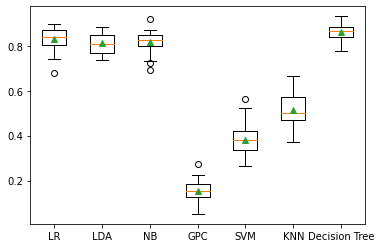

In [34]:
# get models
models, names = get_models()
results = list()
# Models evaluation
for i in range(len(models)):
# evaluate the model and store results
    f2_scores, accuracy_scores = evaluate_model(X, y, models[i])
    results.append(f2_scores)
# summarize and store
    print('F2 - Score : %s %.3f (%.3f)' % (names[i], f2_scores.mean(), f2_scores.std()))
    print('Accuracy : %s %.3f (%.3f)' % (names[i], accuracy_scores.mean(), accuracy_scores.std()))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

#### The models that perform better than the baseline are :
#### - Logistic regression
#### - Linear Discriminant analysis
#### - Naive Bayes
#### - K Nearest Neighbor
#### - Decision Tree

### Out of the 5 models, the model that performs the best is the Decision Tree with an F2 - score of 0.865

### C - Decisition Tree

In [35]:
# Splitting the data into 60% training, 20 % Validation and 20 % Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

#### Baseline Decisition Tree

In [37]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [38]:
y_pred = clf.predict(X_val)

In [39]:
accuracy_score(y_val, y_pred)

0.9564489112227805

In [43]:
y_val.value_counts()

0    498
1     99
Name: is_fraudulent, dtype: int64

In [45]:
(pd.DataFrame(y_pred)).value_counts()

0    504
1     93
dtype: int64

In [46]:
confusion_matrix = confusion_matrix(y_val, y_pred)

<AxesSubplot:>

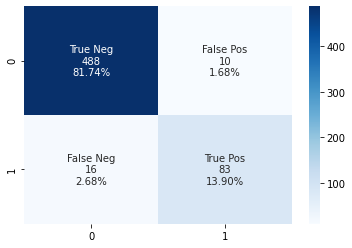

In [53]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt="", cmap='Blues')

In [40]:
f2_score(y_val, y_pred)

0.8486707566462166

In [ ]:
# Tune hyperparameter with grid search

In [ ]:
##### Model evaluation

In [ ]:
#tn, fp, fn, tp = confusion_matrix(y_val,predictions).ravel()

In [ ]:
#(tn, fp, fn, tp)

In [ ]:
## Export the baseline and the improved model

In [ ]:
import joblib
joblib.dump(model, 'model_name.pkl', compress=9)

In [ ]:
joblib.dump(model3, 'model_name.pkl', compress=9)

In [ ]:
# Export the testing dataset

In [ ]:
from numpy import savetxt
savetxt('X_test.csv', X_test, delimiter=',')
savetxt('y_test.csv', y_test, delimiter=',')